## ADD DESCRIPTION FOR THE PROJECT ##

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import regularizers
from keras import metrics

from sklearn.utils import shuffle
from sklearn import model_selection

from operator import itemgetter

Loading data for the ML cup 2022

In [2]:
colnames = ['id', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'class1', 'class2']
mlcup_tr = pd.read_csv("./dataset/ml_cup22/ML-CUP22-TR.csv", sep = ",", names=colnames)
mlcup_tr = mlcup_tr.iloc[7:, :]
mlcup_tr = mlcup_tr.drop('id', axis=1)
mlcup_tr = (mlcup_tr-mlcup_tr.min())/(mlcup_tr.max()-mlcup_tr.min())

In [3]:
x_mlcup_tr = mlcup_tr.iloc[:, 0:9].values
y_mlcup_tr = mlcup_tr.iloc[:, 9:11].values

## Neural Network with Random Search ##

Below we extended the RandomSearch class of the keras_tuner library to perform a cross validation during the phase of model selection (which is not supported by the RandomSearch class).

In [4]:
class CrossValidationRandomSearch(kt.RandomSearch):

    
    cross_validation_partitions = -1
    
    
    def __init__(
        self,
        hypermodel=None,
        objective=None,
        max_trials=10,
        seed=None,
        hyperparameters=None,
        tune_new_entries=True,
        allow_new_entries=True,
        folds_number=1,
        **kwargs
    ):
        self.cross_validation_partitions = model_selection.KFold(folds_number)
        
        
        kt.RandomSearch.__init__(
            self,
            hypermodel=hypermodel,
            objective=objective,
            max_trials=max_trials,
            seed=seed,
            hyperparameters=hyperparameters,
            tune_new_entries=tune_new_entries,
            allow_new_entries=allow_new_entries,
            **kwargs
        )

        
    def run_trial(self, trial, x_train, y_train, *args, **kwargs):
    
        histories_cv = []
        histories_folds = []
        # build a different model for each fold of the cross validation
        for train_indices, test_indices in self.cross_validation_partitions.split(x_train):
            x_cv_train, x_cv_val = x_train[train_indices], x_train[test_indices]
            y_cv_train, y_cv_val = y_train[train_indices], y_train[test_indices]
            histories_folds = super(CrossValidationRandomSearch, self).run_trial(
                trial, x_cv_train, y_cv_train, validation_data=(x_cv_val, y_cv_val), *args, **kwargs
            )
            histories_cv.append(histories_folds)

            histories_folds = []
        # return the performance of each model
        return histories_cv

Below we defined two functions; the first one is used to create a model given a combination of hyperparameters, while the second one select a random combination of hyperparameters in a given range

In [5]:
# instantiate a model given a specific combination of hyperparameters
def set_hyperparameters(units, ridge_lambda, learning_rate, momentum, double_layer):
    model = Sequential()
    model.add(
        Dense(
            units=units,
            activity_regularizer=regularizers.L2(ridge_lambda),
            activation="relu",
        )
    )
    # if double_layer == True, a second layer for the NN is added
    if (double_layer):
        model.add(
            Dense(
                units=units,
                activity_regularizer=regularizers.L2(ridge_lambda),
                activation="relu"
            )
        )
    model.add(Dense(2, activation="linear", activity_regularizer=regularizers.L2(ridge_lambda)))

    
    # the optimizer is the stochastic gradient descent algorithm
    opt = optimizers.SGD(learning_rate=learning_rate, momentum=momentum)

    model.compile(
        optimizer=opt, loss="mean_squared_error", metrics=["mean_absolute_error"]
    )
    
    return model

# extract a random combination of hyperparamaters
def build_regressor(hp, min_units=2, max_units=11, min_ridge_lambda=0.0001, max_ridge_lambda=0.1, min_lr_rate=0.05, 
                max_lr_rate=0.6, min_mom=0.0, max_mom=0.9, linear_lr=False, linear_reg=False, double_layer=False):
    
    
    learning_rate_sampling = "log"
    if (linear_lr):
        learning_rate_sampling = "linear"
    
    ridge_lambda_sampling = "log"
    if(linear_reg):
        ridge_lambda_sampling = "linear"
    
    units_step = 1
    if (max_units - min_units >= 5):
        units_step = 3
    
    # the variable 'units' represents the number of units of the hidden layer
    # by default this value is extracted between 2 and 11 (the user can specify a different interval)
    units = hp.Int("units", min_value=min_units, max_value=max_units, step=units_step)
    
    # the variable 'ridge_lambda' represents the lambda coefficient for ridge regularization
    # by default this value is extracted between 0.0001 and 0.1 with a logarithmic probabilistic law
    # (the user can specify a different interval)
    ridge_lambda = hp.Float(
        "ridge_lambda", min_value=min_ridge_lambda, max_value=max_ridge_lambda, sampling=ridge_lambda_sampling
    )
    
    # the variable 'learning rate' represents the step used by the stochastic gradient descent algorithm
    # by default this value is extracted between 0.1 and 0.6 (the user can specify a different interval)
    learning_rate = hp.Float(
        "learning_rate", min_value=min_lr_rate, max_value=max_lr_rate, sampling=learning_rate_sampling
    )
    
    # the variable 'momentum' represents the coefficient drawn for momentum
    # by default this value is extracted between 0.1 and 0.6 (the user can specify a different interval)
    momentum = hp.Float("momentum", min_value=min_mom, max_value=max_mom, sampling="linear")
    
    # Create the model with the set of hyperparameters drew
    model = set_hyperparameters(
        units=units, ridge_lambda=ridge_lambda, learning_rate=learning_rate, 
        momentum=momentum, double_layer=double_layer
    )
    return model

Let's start searching randomly the best combination of hyperparameters using only one hidden layer.

In [6]:
tuner = CrossValidationRandomSearch(
    hypermodel=build_regressor, # function that return a model given a combination of hyperparameters
    objective=kt.Objective("val_mean_absolute_error", direction="min"), # value to minimize
    max_trials=50, # maximum number of attempts
    executions_per_trial=2, # number of models created for each fold of the cross validation
    overwrite=True,
    directory="results/ml_cup",
    project_name="nn_RandomSearch/single_layer/first/par_hp",
    folds_number=4 # number of folds of the cross validation
)

2022-11-15 21:51:50.827735: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-15 21:51:50.827760: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-15 21:51:50.827776: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (carlo-Aspire-A515-52G): /proc/driver/nvidia/version does not exist
2022-11-15 21:51:50.827983: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


print a brief description of the search space

In [7]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 11, 'step': 3, 'sampling': None}
ridge_lambda (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
learning_rate (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.05, 'max_value': 0.6, 'step': None, 'sampling': 'log'}
momentum (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.9, 'step': None, 'sampling': 'linear'}


In [8]:
tuner.search(
    # the training set for the model selection
    x_mlcup_tr, y_mlcup_tr,
    # maximum number of epochs allowed
    epochs=2500,
    # callback to implement early stopping
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error',  patience=10)],
    shuffle=True
)

Trial 50 Complete [00h 00m 53s]
val_mean_absolute_error: 0.05601986823603511

Best val_mean_absolute_error So Far: 0.05387575412169099
Total elapsed time: 00h 51m 40s
INFO:tensorflow:Oracle triggered exit


In [9]:
best_hp = tuner.get_best_hyperparameters(3)

print("results of the first random search with a single hidden layer\n")
for i in range(len(best_hp)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "ridge_lambda", "learning_rate", "momentum"]:
        print(h_param, best_hp[i].get(h_param))
    print("")

results of the first random search with a single hidden layer

best hyperparameters n. 0
units 11
ridge_lambda 0.002750302510155711
learning_rate 0.15057295308412208
momentum 0.6285288205362497

best hyperparameters n. 1
units 11
ridge_lambda 0.011393696616765262
learning_rate 0.37624850049564146
momentum 0.10253798084422003

best hyperparameters n. 2
units 11
ridge_lambda 0.00873581904893862
learning_rate 0.17603137282019996
momentum 0.23254476781639244



Brief description of the final neural network's structure

In [10]:
f_model = build_regressor(best_hp[0])
f_model.build(
input_shape=(None, 9))

f_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 11)                110       
                                                                 
 dense_3 (Dense)             (None, 2)                 24        
                                                                 
Total params: 134
Trainable params: 134
Non-trainable params: 0
_________________________________________________________________


In [11]:
tuner.results_summary()

Results summary
Results in results/ml_cup/nn_RandomSearch/single_layer/first/par_hp
Showing 10 best trials
Trial summary
Hyperparameters:
units: 11
ridge_lambda: 0.002750302510155711
learning_rate: 0.15057295308412208
momentum: 0.6285288205362497
Score: 0.05387575412169099
Trial summary
Hyperparameters:
units: 11
ridge_lambda: 0.011393696616765262
learning_rate: 0.37624850049564146
momentum: 0.10253798084422003
Score: 0.054292121436446905
Trial summary
Hyperparameters:
units: 11
ridge_lambda: 0.00873581904893862
learning_rate: 0.17603137282019996
momentum: 0.23254476781639244
Score: 0.054517881479114294
Trial summary
Hyperparameters:
units: 8
ridge_lambda: 0.002519574264715003
learning_rate: 0.11142908776910077
momentum: 0.660074809714507
Score: 0.054611173924058676
Trial summary
Hyperparameters:
units: 8
ridge_lambda: 0.00033657951190624004
learning_rate: 0.24896411624971712
momentum: 0.31932245421584415
Score: 0.054919004905968904
Trial summary
Hyperparameters:
units: 11
ridge_lambda

Now we have found a first best set of hyperparameters. At this point, we are ready to perform a second nested random search to explore the space around the best set of hyperparameters found.

In [12]:
h_param = ["units", "ridge_lambda", "learning_rate", "momentum"]

num_units = best_hp[0].get(h_param[0])
ridge_lambda = best_hp[0].get(h_param[1])
learning_rate = best_hp[0].get(h_param[2])
momentum = best_hp[0].get(h_param[3])
double_layer = False

ridge_lambda_min = (ridge_lambda / 10) * 8
ridge_lambda_max = (ridge_lambda / 10) * 12

learning_rate_min = (learning_rate / 10) * 8
learning_rate_max = (learning_rate / 10) * 12

momentum_min = (momentum / 10) * 8
momentum_max = (momentum / 10) * 12

# This lambda function has been used to specify the space of the hyperparameters that we want to explore
x = lambda a: build_regressor(
    a, min_units=num_units, max_units=num_units, min_ridge_lambda=ridge_lambda_min,
    max_ridge_lambda=ridge_lambda_max, min_lr_rate=learning_rate_min,
    max_lr_rate=learning_rate_max,min_mom=momentum_min, max_mom=momentum_max, 
    linear_lr=True, linear_reg=True, double_layer=double_layer
)

tuner2 = CrossValidationRandomSearch(
    hypermodel=x, # function which return a model given a combination of hyperparameters
    objective=kt.Objective("val_mean_absolute_error", direction="min"), # value to minimize
    max_trials=50, # maximum number of attempts
    executions_per_trial=2, # models created for each fold of the cross validation
    overwrite=True,
    directory="results/ml_cup",
    project_name="nn_RandomSearch/single_layer/nested/par_hp",
    folds_number=3 # number of folds of the cross validation
)

Again, below there is a brief summary of the search space

In [13]:
tuner2.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 11, 'max_value': 11, 'step': 1, 'sampling': None}
ridge_lambda (Float)
{'default': 0.002200242008124569, 'conditions': [], 'min_value': 0.002200242008124569, 'max_value': 0.0033003630121868537, 'step': None, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.12045836246729766, 'conditions': [], 'min_value': 0.12045836246729766, 'max_value': 0.18068754370094647, 'step': None, 'sampling': 'linear'}
momentum (Float)
{'default': 0.5028230564289997, 'conditions': [], 'min_value': 0.5028230564289997, 'max_value': 0.7542345846434996, 'step': None, 'sampling': 'linear'}


On the cell below we started the second nested random search (with again only one hidden layer)

In [14]:
tuner2.search(
    x_mlcup_tr, y_mlcup_tr, # training set for the random search 
    epochs=2500, # maximum number of epochs allowed
    # callback to implement early stopping
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)],
    shuffle=True
)

Trial 50 Complete [00h 00m 36s]
val_mean_absolute_error: 0.05427535995841026

Best val_mean_absolute_error So Far: 0.05353809085985025
Total elapsed time: 00h 32m 36s
INFO:tensorflow:Oracle triggered exit


Let's print again the best combination of hyperparameters found during this second nested random search

In [15]:
best_hp2 = tuner2.get_best_hyperparameters(3)

print("results of the second nested random search with a single hidden layer\n")
for i in range(len(best_hp2)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "ridge_lambda", "learning_rate", "momentum"]:
        print(h_param, best_hp2[i].get(h_param))
    print("")

results of the second nested random search with a single hidden layer

best hyperparameters n. 0
units 11
ridge_lambda 0.0032107493161592305
learning_rate 0.12154315078797791
momentum 0.6917081802772191

best hyperparameters n. 1
units 11
ridge_lambda 0.0028184443795411414
learning_rate 0.1521205466399005
momentum 0.7008375458012086

best hyperparameters n. 2
units 11
ridge_lambda 0.002405261602213989
learning_rate 0.16813165089986226
momentum 0.7348343997232151



Brief description of the final neural network's structure

In [16]:
f_model2 = build_regressor(best_hp2[0])
f_model2.build(
input_shape=(None, 9))

f_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 11)                110       
                                                                 
 dense_3 (Dense)             (None, 2)                 24        
                                                                 
Total params: 134
Trainable params: 134
Non-trainable params: 0
_________________________________________________________________


At this point we tried many neural networks using the best hyperparameters found by the second nested random search. Below we split the design set between training set and validation set. Remember that here we are using only one hidden layer

In [17]:
subset_size = int(0.3 * len(x_mlcup_tr))

index = np.random.choice(len(x_mlcup_tr), subset_size, replace=False)
index = np.sort(index)

x_mlcup_ds = x_mlcup_tr
y_mlcup_ds = y_mlcup_tr

x_mlcup_vl = x_mlcup_ds[index]
y_mlcup_vl = y_mlcup_ds[index]

x_mlcup_tr = np.delete(x_mlcup_ds, index, 0)
y_mlcup_tr = np.delete(y_mlcup_ds, index, 0)

In [18]:
n_trials = 10

models = [None]*n_trials

for i in range(n_trials):
    models[i] = build_regressor(best_hp2[0])

n_epochs = 1000
hist = [None]*n_trials

for i in range(n_trials):
        hist[i] = models[i].fit(
            x=x_mlcup_tr,
            y=y_mlcup_tr,
            validation_data=(x_mlcup_vl, y_mlcup_vl),
            epochs=n_epochs,
            shuffle=True,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)]
        )

Epoch 1/1000
33/33 [==============================] - 1s 6ms/step - loss: 0.0554 - mean_absolute_error: 0.1661 - val_loss: 0.0280 - val_mean_absolute_error: 0.1199
Epoch 2/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0255 - mean_absolute_error: 0.1117 - val_loss: 0.0220 - val_mean_absolute_error: 0.1080
Epoch 3/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0208 - mean_absolute_error: 0.1015 - val_loss: 0.0178 - val_mean_absolute_error: 0.0949
Epoch 4/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0183 - mean_absolute_error: 0.0941 - val_loss: 0.0158 - val_mean_absolute_error: 0.0888
Epoch 5/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0165 - mean_absolute_error: 0.0879 - val_loss: 0.0142 - val_mean_absolute_error: 0.0824
Epoch 6/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0147 - mean_absolute_error: 0.0817 - val_loss: 0.0135 - val_mean_absolute_error: 0.0790
Epoch 7/1000
33/

Epoch 51/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0082 - mean_absolute_error: 0.0564 - val_loss: 0.0076 - val_mean_absolute_error: 0.0567
Epoch 52/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0082 - mean_absolute_error: 0.0564 - val_loss: 0.0073 - val_mean_absolute_error: 0.0546
Epoch 53/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0082 - mean_absolute_error: 0.0562 - val_loss: 0.0075 - val_mean_absolute_error: 0.0552
Epoch 54/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - mean_absolute_error: 0.0558 - val_loss: 0.0077 - val_mean_absolute_error: 0.0555
Epoch 55/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - mean_absolute_error: 0.0559 - val_loss: 0.0073 - val_mean_absolute_error: 0.0542
Epoch 56/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - mean_absolute_error: 0.0554 - val_loss: 0.0073 - val_mean_absolute_error: 0.0542
Epoch 57/1

33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - mean_absolute_error: 0.0534 - val_loss: 0.0069 - val_mean_absolute_error: 0.0523
Epoch 101/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - mean_absolute_error: 0.0532 - val_loss: 0.0067 - val_mean_absolute_error: 0.0519
Epoch 102/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - mean_absolute_error: 0.0532 - val_loss: 0.0070 - val_mean_absolute_error: 0.0538
Epoch 103/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - mean_absolute_error: 0.0535 - val_loss: 0.0066 - val_mean_absolute_error: 0.0510
Epoch 104/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - mean_absolute_error: 0.0528 - val_loss: 0.0067 - val_mean_absolute_error: 0.0517
Epoch 105/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - mean_absolute_error: 0.0530 - val_loss: 0.0066 - val_mean_absolute_error: 0.0508
Epoch 106/1000
33/3

Epoch 31/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0094 - mean_absolute_error: 0.0604 - val_loss: 0.0087 - val_mean_absolute_error: 0.0595
Epoch 32/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0095 - mean_absolute_error: 0.0606 - val_loss: 0.0086 - val_mean_absolute_error: 0.0610
Epoch 33/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0093 - mean_absolute_error: 0.0597 - val_loss: 0.0081 - val_mean_absolute_error: 0.0565
Epoch 34/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0092 - mean_absolute_error: 0.0593 - val_loss: 0.0081 - val_mean_absolute_error: 0.0577
Epoch 35/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0091 - mean_absolute_error: 0.0592 - val_loss: 0.0080 - val_mean_absolute_error: 0.0564
Epoch 36/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0091 - mean_absolute_error: 0.0588 - val_loss: 0.0080 - val_mean_absolute_error: 0.0567
Epoch 37/1

Epoch 81/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - mean_absolute_error: 0.0527 - val_loss: 0.0068 - val_mean_absolute_error: 0.0508
Epoch 82/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - mean_absolute_error: 0.0526 - val_loss: 0.0072 - val_mean_absolute_error: 0.0549
Epoch 83/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - mean_absolute_error: 0.0530 - val_loss: 0.0068 - val_mean_absolute_error: 0.0518
Epoch 84/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - mean_absolute_error: 0.0524 - val_loss: 0.0069 - val_mean_absolute_error: 0.0519
Epoch 85/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - mean_absolute_error: 0.0528 - val_loss: 0.0072 - val_mean_absolute_error: 0.0522
Epoch 86/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - mean_absolute_error: 0.0532 - val_loss: 0.0069 - val_mean_absolute_error: 0.0512
Epoch 87/1

Epoch 33/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0091 - mean_absolute_error: 0.0597 - val_loss: 0.0086 - val_mean_absolute_error: 0.0591
Epoch 34/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0091 - mean_absolute_error: 0.0596 - val_loss: 0.0084 - val_mean_absolute_error: 0.0591
Epoch 35/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0091 - mean_absolute_error: 0.0594 - val_loss: 0.0082 - val_mean_absolute_error: 0.0581
Epoch 36/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0090 - mean_absolute_error: 0.0591 - val_loss: 0.0081 - val_mean_absolute_error: 0.0580
Epoch 37/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0090 - mean_absolute_error: 0.0593 - val_loss: 0.0082 - val_mean_absolute_error: 0.0590
Epoch 38/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0089 - mean_absolute_error: 0.0590 - val_loss: 0.0081 - val_mean_absolute_error: 0.0578
Epoch 39/1

Epoch 4/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0188 - mean_absolute_error: 0.0994 - val_loss: 0.0175 - val_mean_absolute_error: 0.0943
Epoch 5/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0175 - mean_absolute_error: 0.0937 - val_loss: 0.0159 - val_mean_absolute_error: 0.0875
Epoch 6/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0162 - mean_absolute_error: 0.0882 - val_loss: 0.0152 - val_mean_absolute_error: 0.0828
Epoch 7/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0149 - mean_absolute_error: 0.0827 - val_loss: 0.0142 - val_mean_absolute_error: 0.0801
Epoch 8/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0143 - mean_absolute_error: 0.0792 - val_loss: 0.0132 - val_mean_absolute_error: 0.0775
Epoch 9/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0134 - mean_absolute_error: 0.0764 - val_loss: 0.0127 - val_mean_absolute_error: 0.0743
Epoch 10/1000
33

Epoch 54/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - mean_absolute_error: 0.0546 - val_loss: 0.0073 - val_mean_absolute_error: 0.0531
Epoch 55/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0079 - mean_absolute_error: 0.0546 - val_loss: 0.0072 - val_mean_absolute_error: 0.0527
Epoch 56/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - mean_absolute_error: 0.0548 - val_loss: 0.0075 - val_mean_absolute_error: 0.0537
Epoch 57/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0079 - mean_absolute_error: 0.0540 - val_loss: 0.0072 - val_mean_absolute_error: 0.0536
Epoch 58/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - mean_absolute_error: 0.0545 - val_loss: 0.0071 - val_mean_absolute_error: 0.0529
Epoch 59/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - mean_absolute_error: 0.0545 - val_loss: 0.0072 - val_mean_absolute_error: 0.0528
Epoch 60/1

33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - mean_absolute_error: 0.0535 - val_loss: 0.0068 - val_mean_absolute_error: 0.0524
Epoch 104/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - mean_absolute_error: 0.0536 - val_loss: 0.0068 - val_mean_absolute_error: 0.0519
Epoch 105/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - mean_absolute_error: 0.0536 - val_loss: 0.0071 - val_mean_absolute_error: 0.0540
Epoch 106/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - mean_absolute_error: 0.0532 - val_loss: 0.0068 - val_mean_absolute_error: 0.0518
Epoch 107/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - mean_absolute_error: 0.0530 - val_loss: 0.0081 - val_mean_absolute_error: 0.0600
Epoch 108/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0079 - mean_absolute_error: 0.0544 - val_loss: 0.0068 - val_mean_absolute_error: 0.0520
Epoch 109/1000
33/3

33/33 [==============================] - 0s 2ms/step - loss: 0.0095 - mean_absolute_error: 0.0613 - val_loss: 0.0096 - val_mean_absolute_error: 0.0620
Epoch 24/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0094 - mean_absolute_error: 0.0612 - val_loss: 0.0089 - val_mean_absolute_error: 0.0609
Epoch 25/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0094 - mean_absolute_error: 0.0607 - val_loss: 0.0090 - val_mean_absolute_error: 0.0618
Epoch 26/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0093 - mean_absolute_error: 0.0607 - val_loss: 0.0088 - val_mean_absolute_error: 0.0600
Epoch 27/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0093 - mean_absolute_error: 0.0602 - val_loss: 0.0088 - val_mean_absolute_error: 0.0597
Epoch 28/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0092 - mean_absolute_error: 0.0597 - val_loss: 0.0090 - val_mean_absolute_error: 0.0619
Epoch 29/1000
33/33 [===

Epoch 73/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0082 - mean_absolute_error: 0.0566 - val_loss: 0.0078 - val_mean_absolute_error: 0.0578
Epoch 74/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - mean_absolute_error: 0.0568 - val_loss: 0.0077 - val_mean_absolute_error: 0.0574
Epoch 75/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0082 - mean_absolute_error: 0.0566 - val_loss: 0.0075 - val_mean_absolute_error: 0.0553
Epoch 76/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - mean_absolute_error: 0.0566 - val_loss: 0.0078 - val_mean_absolute_error: 0.0572
Epoch 77/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - mean_absolute_error: 0.0566 - val_loss: 0.0074 - val_mean_absolute_error: 0.0553
Epoch 78/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0082 - mean_absolute_error: 0.0566 - val_loss: 0.0075 - val_mean_absolute_error: 0.0557
Epoch 79/1

33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - mean_absolute_error: 0.0561 - val_loss: 0.0073 - val_mean_absolute_error: 0.0560
Epoch 123/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - mean_absolute_error: 0.0559 - val_loss: 0.0072 - val_mean_absolute_error: 0.0546
Epoch 124/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - mean_absolute_error: 0.0559 - val_loss: 0.0074 - val_mean_absolute_error: 0.0549
Epoch 125/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0079 - mean_absolute_error: 0.0554 - val_loss: 0.0080 - val_mean_absolute_error: 0.0565
Epoch 1/1000
33/33 [==============================] - 1s 5ms/step - loss: 0.0343 - mean_absolute_error: 0.1274 - val_loss: 0.0181 - val_mean_absolute_error: 0.0841
Epoch 2/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0174 - mean_absolute_error: 0.0816 - val_loss: 0.0144 - val_mean_absolute_error: 0.0730
Epoch 3/1000
33/33 [===

Epoch 47/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - mean_absolute_error: 0.0553 - val_loss: 0.0074 - val_mean_absolute_error: 0.0540
Epoch 48/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0082 - mean_absolute_error: 0.0556 - val_loss: 0.0074 - val_mean_absolute_error: 0.0545
Epoch 49/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - mean_absolute_error: 0.0562 - val_loss: 0.0071 - val_mean_absolute_error: 0.0534
Epoch 50/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - mean_absolute_error: 0.0547 - val_loss: 0.0074 - val_mean_absolute_error: 0.0560
Epoch 51/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0082 - mean_absolute_error: 0.0551 - val_loss: 0.0077 - val_mean_absolute_error: 0.0547
Epoch 52/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - mean_absolute_error: 0.0549 - val_loss: 0.0078 - val_mean_absolute_error: 0.0540
Epoch 53/1

Epoch 12/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0119 - mean_absolute_error: 0.0693 - val_loss: 0.0111 - val_mean_absolute_error: 0.0665
Epoch 13/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0116 - mean_absolute_error: 0.0684 - val_loss: 0.0102 - val_mean_absolute_error: 0.0637
Epoch 14/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0115 - mean_absolute_error: 0.0681 - val_loss: 0.0103 - val_mean_absolute_error: 0.0640
Epoch 15/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0113 - mean_absolute_error: 0.0680 - val_loss: 0.0100 - val_mean_absolute_error: 0.0632
Epoch 16/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0111 - mean_absolute_error: 0.0670 - val_loss: 0.0101 - val_mean_absolute_error: 0.0640
Epoch 17/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0110 - mean_absolute_error: 0.0665 - val_loss: 0.0098 - val_mean_absolute_error: 0.0625
Epoch 18/1

Epoch 62/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0089 - mean_absolute_error: 0.0601 - val_loss: 0.0080 - val_mean_absolute_error: 0.0585
Epoch 63/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0087 - mean_absolute_error: 0.0594 - val_loss: 0.0080 - val_mean_absolute_error: 0.0584
Epoch 64/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0087 - mean_absolute_error: 0.0590 - val_loss: 0.0079 - val_mean_absolute_error: 0.0584
Epoch 65/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0087 - mean_absolute_error: 0.0589 - val_loss: 0.0078 - val_mean_absolute_error: 0.0574
Epoch 66/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0087 - mean_absolute_error: 0.0591 - val_loss: 0.0079 - val_mean_absolute_error: 0.0586
Epoch 67/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0087 - mean_absolute_error: 0.0598 - val_loss: 0.0081 - val_mean_absolute_error: 0.0590
Epoch 68/1

Epoch 8/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0122 - mean_absolute_error: 0.0728 - val_loss: 0.0107 - val_mean_absolute_error: 0.0659
Epoch 9/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0119 - mean_absolute_error: 0.0715 - val_loss: 0.0106 - val_mean_absolute_error: 0.0652
Epoch 10/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0119 - mean_absolute_error: 0.0715 - val_loss: 0.0103 - val_mean_absolute_error: 0.0646
Epoch 11/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0117 - mean_absolute_error: 0.0705 - val_loss: 0.0104 - val_mean_absolute_error: 0.0651
Epoch 12/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0115 - mean_absolute_error: 0.0698 - val_loss: 0.0102 - val_mean_absolute_error: 0.0653
Epoch 13/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0113 - mean_absolute_error: 0.0694 - val_loss: 0.0106 - val_mean_absolute_error: 0.0669
Epoch 14/100

Epoch 58/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0091 - mean_absolute_error: 0.0606 - val_loss: 0.0081 - val_mean_absolute_error: 0.0561
Epoch 59/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0093 - mean_absolute_error: 0.0618 - val_loss: 0.0080 - val_mean_absolute_error: 0.0559
Epoch 60/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0091 - mean_absolute_error: 0.0610 - val_loss: 0.0083 - val_mean_absolute_error: 0.0582
Epoch 61/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0092 - mean_absolute_error: 0.0612 - val_loss: 0.0081 - val_mean_absolute_error: 0.0559
Epoch 62/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0091 - mean_absolute_error: 0.0613 - val_loss: 0.0093 - val_mean_absolute_error: 0.0657
Epoch 63/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0091 - mean_absolute_error: 0.0611 - val_loss: 0.0093 - val_mean_absolute_error: 0.0628
Epoch 64/1

33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - mean_absolute_error: 0.0583 - val_loss: 0.0074 - val_mean_absolute_error: 0.0538
Epoch 108/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - mean_absolute_error: 0.0587 - val_loss: 0.0076 - val_mean_absolute_error: 0.0557
Epoch 109/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0084 - mean_absolute_error: 0.0581 - val_loss: 0.0083 - val_mean_absolute_error: 0.0595
Epoch 110/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - mean_absolute_error: 0.0591 - val_loss: 0.0080 - val_mean_absolute_error: 0.0574
Epoch 111/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0082 - mean_absolute_error: 0.0568 - val_loss: 0.0075 - val_mean_absolute_error: 0.0544
Epoch 112/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0087 - mean_absolute_error: 0.0600 - val_loss: 0.0080 - val_mean_absolute_error: 0.0588
Epoch 113/1000
33/3

Epoch 43/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - mean_absolute_error: 0.0579 - val_loss: 0.0078 - val_mean_absolute_error: 0.0565
Epoch 44/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - mean_absolute_error: 0.0578 - val_loss: 0.0081 - val_mean_absolute_error: 0.0573
Epoch 45/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - mean_absolute_error: 0.0579 - val_loss: 0.0082 - val_mean_absolute_error: 0.0595
Epoch 46/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0084 - mean_absolute_error: 0.0574 - val_loss: 0.0079 - val_mean_absolute_error: 0.0569
Epoch 47/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - mean_absolute_error: 0.0585 - val_loss: 0.0081 - val_mean_absolute_error: 0.0577
Epoch 48/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - mean_absolute_error: 0.0578 - val_loss: 0.0078 - val_mean_absolute_error: 0.0576
Epoch 49/1

Epoch 93/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0079 - mean_absolute_error: 0.0560 - val_loss: 0.0073 - val_mean_absolute_error: 0.0543
Epoch 94/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - mean_absolute_error: 0.0558 - val_loss: 0.0076 - val_mean_absolute_error: 0.0552
Epoch 95/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - mean_absolute_error: 0.0550 - val_loss: 0.0074 - val_mean_absolute_error: 0.0559
Epoch 96/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - mean_absolute_error: 0.0556 - val_loss: 0.0071 - val_mean_absolute_error: 0.0540
Epoch 97/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - mean_absolute_error: 0.0552 - val_loss: 0.0072 - val_mean_absolute_error: 0.0548
Epoch 98/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0079 - mean_absolute_error: 0.0555 - val_loss: 0.0072 - val_mean_absolute_error: 0.0541
Epoch 99/1

Epoch 41/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0102 - mean_absolute_error: 0.0682 - val_loss: 0.0095 - val_mean_absolute_error: 0.0663
Epoch 42/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0102 - mean_absolute_error: 0.0683 - val_loss: 0.0092 - val_mean_absolute_error: 0.0654
Epoch 43/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0104 - mean_absolute_error: 0.0686 - val_loss: 0.0093 - val_mean_absolute_error: 0.0655
Epoch 44/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0103 - mean_absolute_error: 0.0686 - val_loss: 0.0095 - val_mean_absolute_error: 0.0657
Epoch 45/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0102 - mean_absolute_error: 0.0688 - val_loss: 0.0092 - val_mean_absolute_error: 0.0645
Epoch 46/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0102 - mean_absolute_error: 0.0681 - val_loss: 0.0095 - val_mean_absolute_error: 0.0677
Epoch 47/1

Epoch 91/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0088 - mean_absolute_error: 0.0609 - val_loss: 0.0080 - val_mean_absolute_error: 0.0587
Epoch 92/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0091 - mean_absolute_error: 0.0624 - val_loss: 0.0097 - val_mean_absolute_error: 0.0660
Epoch 93/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0090 - mean_absolute_error: 0.0619 - val_loss: 0.0080 - val_mean_absolute_error: 0.0584
Epoch 94/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0088 - mean_absolute_error: 0.0609 - val_loss: 0.0080 - val_mean_absolute_error: 0.0585
Epoch 95/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0088 - mean_absolute_error: 0.0611 - val_loss: 0.0090 - val_mean_absolute_error: 0.0616
Epoch 96/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0090 - mean_absolute_error: 0.0617 - val_loss: 0.0080 - val_mean_absolute_error: 0.0587
Epoch 97/1

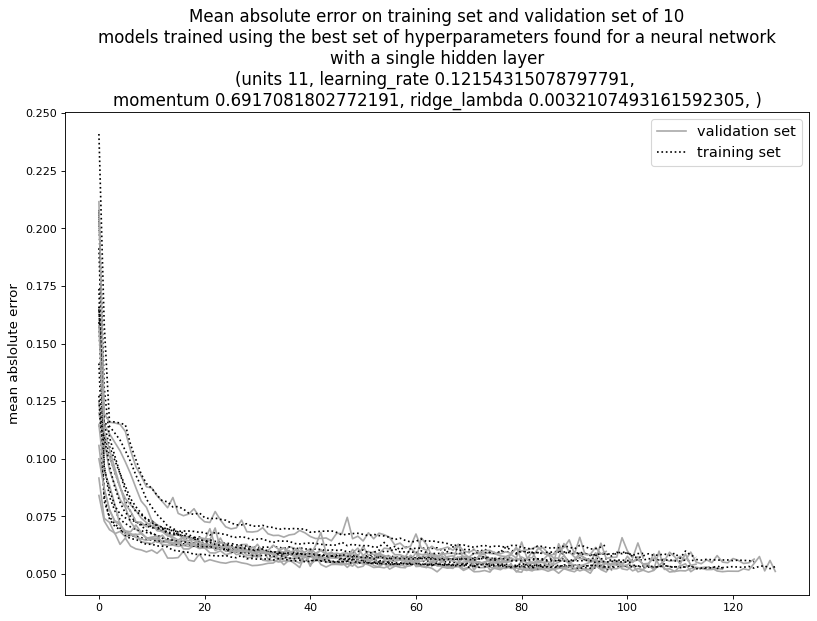

In [19]:
total_hp = 4
labels = ""
count = 1
for h_param in ["units", "learning_rate", "momentum", "ridge_lambda"]:
    labels += h_param + " " + str(best_hp2[0].get(h_param)) + ", "
    if(count % 2 == 0 and count != total_hp):
        labels += "\n"
    count += 1

list_values_val = [None]*n_trials
list_values_tr = [None]*n_trials

colours = ["darkgray", "black"]
linestyles = ["solid", "dotted"]

for i in range(n_trials):
    list_values_val[i] = hist[i].history['val_mean_absolute_error']
    list_values_tr[i] = hist[i].history['mean_absolute_error']
        
max_length = 0
for i in range(n_trials):
    if (max_length < len(list_values_tr[i])):
        max_length = len(list_values_tr[i])
        
time_ep = list(range(max_length))

plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values_val[i])], list_values_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values_tr[i])], list_values_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

legend = ["validation set", "training set"]

plt.title(
    "Mean absolute error on training set and validation set of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with a single hidden layer\n("
    + labels + ")", size=15
)

plt.ylabel("mean abslolute error", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/mae_single_layer.png")
plt.show()

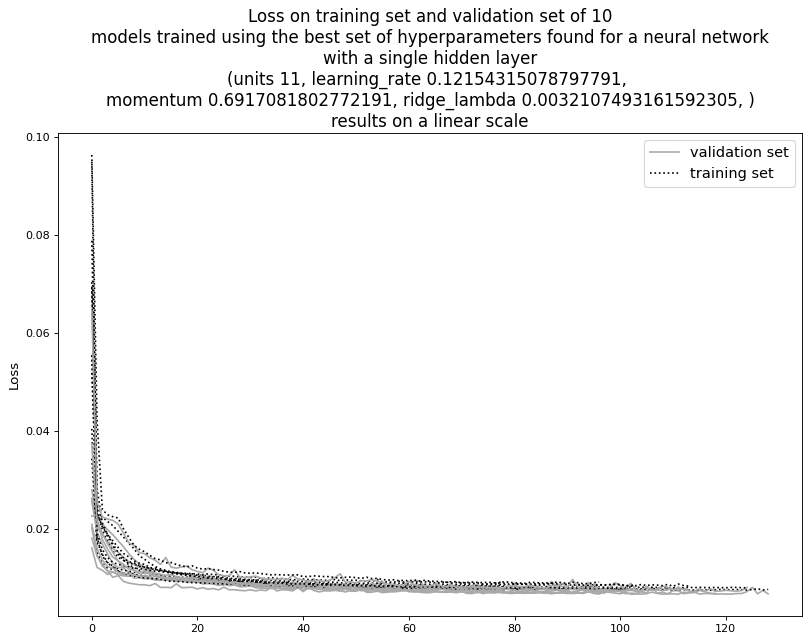

In [20]:
list_values2_val = [None]*n_trials
list_values2_tr = [None]*n_trials

for i in range(n_trials):
    list_values2_val[i] = hist[i].history['val_loss']
    list_values2_tr[i] = hist[i].history['loss']

plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values2_val[i])], list_values2_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values2_tr[i])], list_values2_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

plt.title(
    "Loss on training set and validation set of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with a single hidden layer\n("
    + labels + ")\n" +
    "results on a linear scale", size=15
)

plt.ylabel("Loss", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/ms_loss_single_layer.png")
plt.show()

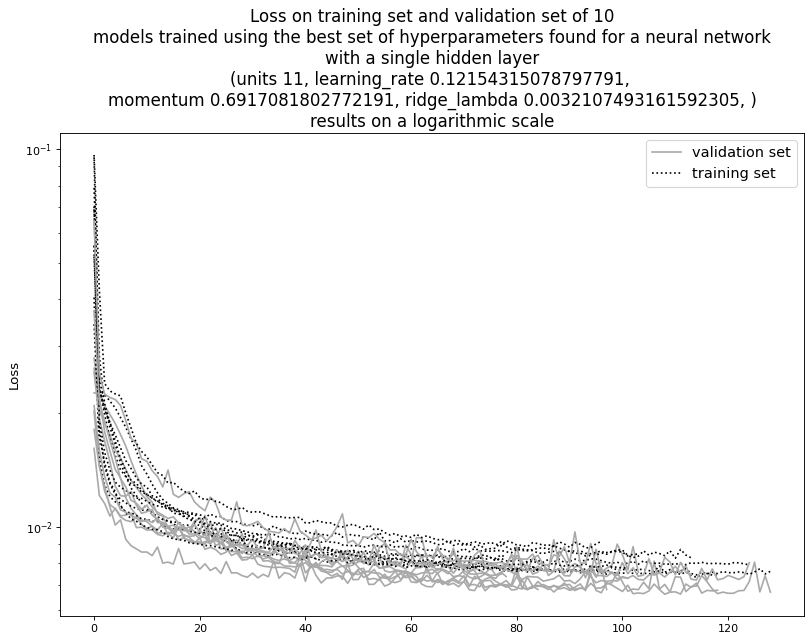

In [21]:
plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values2_val[i])], list_values2_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values2_tr[i])], list_values2_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

plt.title(
    "Loss on training set and validation set of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with a single hidden layer\n("
    + labels + ")\n" +
    "results on a logarithmic scale", size=15
)

plt.ylabel("Loss", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/ms_loss_single_layer_log.png")
plt.yscale('log')
plt.show()

At this point we tried to add a second hidden layer to study whether its presence could help the neural network to generalise the problem.

Therefore we restarted the random search from scratch

In [22]:
x_mlcup_tr = x_mlcup_ds
y_mlcup_tr = y_mlcup_ds

num_units_min = 2
num_units_max = 5
double_layer = True


# This lambda function has been used to specify the space of the hyperparameters that we want to explore
x = lambda a: build_regressor(
    a, min_units=num_units_min, max_units=num_units_max, double_layer=double_layer
)


tuner3 = CrossValidationRandomSearch(
    hypermodel=x, # function that return a model given a combination of hyperparameters
    objective=kt.Objective("val_mean_absolute_error", direction="min"), # value to minimize
    max_trials=50, # maximum number of attempts
    executions_per_trial=2, # number of models created for each fold of the cross validation
    overwrite=True,
    directory="results/ml_cup",
    project_name="nn_RandomSearch/double_layer/first/par_hp",
    folds_number=4 # number of folds of the cross validation
)

print a brief description of the search space

In [23]:
tuner3.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': None}
ridge_lambda (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
learning_rate (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.05, 'max_value': 0.6, 'step': None, 'sampling': 'log'}
momentum (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.9, 'step': None, 'sampling': 'linear'}


In [24]:
tuner3.search(
    # the training set for the model selection
    x_mlcup_tr, y_mlcup_tr,
    # maximum number of epochs allowed
    epochs=2500,
    # callback to implement early stopping
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error',  patience=10)],
    shuffle=True
)

Trial 50 Complete [00h 00m 28s]
val_mean_absolute_error: 0.11138071678578854

Best val_mean_absolute_error So Far: 0.055289380718022585
Total elapsed time: 00h 40m 51s
INFO:tensorflow:Oracle triggered exit


In [25]:
best_hp3 = tuner3.get_best_hyperparameters(3)

print("results of the first random search with a double hidden layer\n")
for i in range(len(best_hp3)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "ridge_lambda", "learning_rate", "momentum"]:
        print(h_param, best_hp3[i].get(h_param))
    print("")

results of the first random search with a double hidden layer

best hyperparameters n. 0
units 5
ridge_lambda 0.0036667950668043754
learning_rate 0.23571045068431526
momentum 0.4926804506313723

best hyperparameters n. 1
units 5
ridge_lambda 0.00012498373020169341
learning_rate 0.10867333673065341
momentum 0.6018767140807407

best hyperparameters n. 2
units 5
ridge_lambda 0.0162724116399185
learning_rate 0.0801089526072858
momentum 0.5176679435023571



Brief description of the final neural network's structure

In [26]:
f_model3 = build_regressor(best_hp3[0])
f_model3.build(
input_shape=(None, 9))

f_model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 5)                 50        
                                                                 
 dense_4 (Dense)             (None, 2)                 12        
                                                                 
Total params: 62
Trainable params: 62
Non-trainable params: 0
_________________________________________________________________


In [27]:
tuner3.results_summary()

Results summary
Results in results/ml_cup/nn_RandomSearch/double_layer/first/par_hp
Showing 10 best trials
Trial summary
Hyperparameters:
units: 5
ridge_lambda: 0.0036667950668043754
learning_rate: 0.23571045068431526
momentum: 0.4926804506313723
Score: 0.055289380718022585
Trial summary
Hyperparameters:
units: 5
ridge_lambda: 0.00012498373020169341
learning_rate: 0.10867333673065341
momentum: 0.6018767140807407
Score: 0.05641892831772566
Trial summary
Hyperparameters:
units: 5
ridge_lambda: 0.0162724116399185
learning_rate: 0.0801089526072858
momentum: 0.5176679435023571
Score: 0.058650548569858074
Trial summary
Hyperparameters:
units: 5
ridge_lambda: 0.000278780052227871
learning_rate: 0.30824493550048926
momentum: 0.43587650976280057
Score: 0.05947931297123432
Trial summary
Hyperparameters:
units: 4
ridge_lambda: 0.0010829283900041387
learning_rate: 0.08157247583838582
momentum: 0.31637298619563464
Score: 0.06483181938529015
Trial summary
Hyperparameters:
units: 4
ridge_lambda: 0.01

Again, by now we have found a first best set of hyperparameters. We want to refine them by performing a second nested random search around this best combination of hyperparameters.

In [28]:
h_param = ["units", "ridge_lambda", "learning_rate", "momentum"]

num_units = best_hp3[0].get(h_param[0])
ridge_lambda = best_hp3[0].get(h_param[1])
learning_rate = best_hp3[0].get(h_param[2])
momentum = best_hp3[0].get(h_param[3])
double_layer = True

ridge_lambda_min = (ridge_lambda / 10) * 8
ridge_lambda_max = (ridge_lambda / 10) * 12

learning_rate_min = (learning_rate / 10) * 8
learning_rate_max = (learning_rate / 10) * 12

momentum_min = (momentum / 10) * 8
momentum_max = (momentum / 10) * 12

# This lambda function has been used to specify the space of the hyperparameters that we want to explore
x = lambda a: build_regressor(
    a, min_units=num_units, max_units=num_units, min_ridge_lambda=ridge_lambda_min,
    max_ridge_lambda=ridge_lambda_max, min_lr_rate=learning_rate_min,
    max_lr_rate=learning_rate_max,min_mom=momentum_min, max_mom=momentum_max, linear_lr=True,
    linear_reg=True, double_layer=double_layer
)

tuner4 = CrossValidationRandomSearch(
    hypermodel=x, # function which return a model given a combination of hyperparameters
    objective=kt.Objective("val_mean_absolute_error", direction="min"), # value to minimize
    max_trials=50, # maximum number of attempts
    executions_per_trial=2, # models created for each fold of the cross validation
    overwrite=True,
    directory="results/ml_cup",
    project_name="nn_RandomSearch/double_layer/nested/par_hp",
    folds_number=3
)

Again, below there is a brief summary of the search space

In [29]:
tuner4.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 5, 'step': 1, 'sampling': None}
ridge_lambda (Float)
{'default': 0.0029334360534435003, 'conditions': [], 'min_value': 0.0029334360534435003, 'max_value': 0.00440015408016525, 'step': None, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.1885683605474522, 'conditions': [], 'min_value': 0.1885683605474522, 'max_value': 0.28285254082117833, 'step': None, 'sampling': 'linear'}
momentum (Float)
{'default': 0.3941443605050978, 'conditions': [], 'min_value': 0.3941443605050978, 'max_value': 0.5912165407576467, 'step': None, 'sampling': 'linear'}


In [30]:
tuner4.search(
    x_mlcup_tr, y_mlcup_tr, # training set for the random search 
    epochs=2500, # maximum number of epochs allowed
    # callback to implement early stopping
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)],
    shuffle=True
)

Trial 50 Complete [00h 00m 23s]
val_mean_absolute_error: 0.07617790065705776

Best val_mean_absolute_error So Far: 0.055178474014004074
Total elapsed time: 00h 23m 37s
INFO:tensorflow:Oracle triggered exit


Let's print again the best combination of hyperparameters found during this second nested random search with two hidden layers

In [31]:
best_hp4 = tuner4.get_best_hyperparameters(3)

print("results of the second nested random search with a single hidden layer\n")
for i in range(len(best_hp4)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "ridge_lambda", "learning_rate", "momentum"]:
        print(h_param, best_hp4[i].get(h_param))
    print("")

results of the second nested random search with a single hidden layer

best hyperparameters n. 0
units 5
ridge_lambda 0.0033271737989657188
learning_rate 0.2405207468974957
momentum 0.5274950071294506

best hyperparameters n. 1
units 5
ridge_lambda 0.0029988186121265724
learning_rate 0.19752665440335898
momentum 0.5727099898986395

best hyperparameters n. 2
units 5
ridge_lambda 0.004269501765516299
learning_rate 0.20371098661031437
momentum 0.5777300232471868



Brief description of the final neural network's structure

In [32]:
f_model4 = build_regressor(best_hp4[0])
f_model4.build(
input_shape=(None, 9))

f_model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 5)                 50        
                                                                 
 dense_4 (Dense)             (None, 2)                 12        
                                                                 
Total params: 62
Trainable params: 62
Non-trainable params: 0
_________________________________________________________________


At this point we tried many neural networks using the best hyperparameters found by the second nested random search. Below we split the design set between training set and validation set. Remember that here we are using two hidden layers

In [33]:
subset_size = int(0.3 * len(x_mlcup_tr))

x_mlcup_ds = x_mlcup_tr
y_mlcup_ds = y_mlcup_tr

x_mlcup_vl = x_mlcup_ds[index]
y_mlcup_vl = y_mlcup_ds[index]

x_mlcup_tr = np.delete(x_mlcup_ds, index, 0)
y_mlcup_tr = np.delete(y_mlcup_ds, index, 0)

In [34]:
n_trials = 10

models2 = [None]*n_trials

for i in range(n_trials):
    models2[i] = build_regressor(best_hp4[0])

n_epochs = 1000
hist2 = [None]*n_trials

for i in range(n_trials):
        hist2[i] = models2[i].fit(
            x=x_mlcup_tr,
            y=y_mlcup_tr,
            validation_data=(x_mlcup_vl, y_mlcup_vl),
            epochs=n_epochs,
            shuffle=True,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)]
        )

Epoch 1/1000
33/33 [==============================] - 1s 6ms/step - loss: 0.0325 - mean_absolute_error: 0.1214 - val_loss: 0.0198 - val_mean_absolute_error: 0.0978
Epoch 2/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0200 - mean_absolute_error: 0.0982 - val_loss: 0.0175 - val_mean_absolute_error: 0.0914
Epoch 3/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0185 - mean_absolute_error: 0.0930 - val_loss: 0.0160 - val_mean_absolute_error: 0.0849
Epoch 4/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0172 - mean_absolute_error: 0.0885 - val_loss: 0.0150 - val_mean_absolute_error: 0.0812
Epoch 5/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0162 - mean_absolute_error: 0.0848 - val_loss: 0.0141 - val_mean_absolute_error: 0.0782
Epoch 6/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0158 - mean_absolute_error: 0.0836 - val_loss: 0.0135 - val_mean_absolute_error: 0.0759
Epoch 7/1000
33/

Epoch 51/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0109 - mean_absolute_error: 0.0698 - val_loss: 0.0094 - val_mean_absolute_error: 0.0657
Epoch 52/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0107 - mean_absolute_error: 0.0695 - val_loss: 0.0091 - val_mean_absolute_error: 0.0634
Epoch 53/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0106 - mean_absolute_error: 0.0691 - val_loss: 0.0090 - val_mean_absolute_error: 0.0633
Epoch 54/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0107 - mean_absolute_error: 0.0691 - val_loss: 0.0095 - val_mean_absolute_error: 0.0657
Epoch 55/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0109 - mean_absolute_error: 0.0706 - val_loss: 0.0093 - val_mean_absolute_error: 0.0654
Epoch 56/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0105 - mean_absolute_error: 0.0686 - val_loss: 0.0113 - val_mean_absolute_error: 0.0725
Epoch 57/1

Epoch 24/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0210 - mean_absolute_error: 0.1093 - val_loss: 0.0197 - val_mean_absolute_error: 0.1076
Epoch 25/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0211 - mean_absolute_error: 0.1096 - val_loss: 0.0198 - val_mean_absolute_error: 0.1080
Epoch 26/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0211 - mean_absolute_error: 0.1098 - val_loss: 0.0198 - val_mean_absolute_error: 0.1073
Epoch 27/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0208 - mean_absolute_error: 0.1092 - val_loss: 0.0204 - val_mean_absolute_error: 0.1092
Epoch 28/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0210 - mean_absolute_error: 0.1101 - val_loss: 0.0202 - val_mean_absolute_error: 0.1086
Epoch 29/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0210 - mean_absolute_error: 0.1103 - val_loss: 0.0213 - val_mean_absolute_error: 0.1131
Epoch 30/1

Epoch 23/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0093 - mean_absolute_error: 0.0608 - val_loss: 0.0081 - val_mean_absolute_error: 0.0576
Epoch 24/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0090 - mean_absolute_error: 0.0599 - val_loss: 0.0087 - val_mean_absolute_error: 0.0608
Epoch 25/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0092 - mean_absolute_error: 0.0607 - val_loss: 0.0080 - val_mean_absolute_error: 0.0574
Epoch 26/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0088 - mean_absolute_error: 0.0593 - val_loss: 0.0079 - val_mean_absolute_error: 0.0570
Epoch 27/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0089 - mean_absolute_error: 0.0593 - val_loss: 0.0079 - val_mean_absolute_error: 0.0573
Epoch 28/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0087 - mean_absolute_error: 0.0593 - val_loss: 0.0083 - val_mean_absolute_error: 0.0578
Epoch 29/1

Epoch 12/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0116 - mean_absolute_error: 0.0696 - val_loss: 0.0107 - val_mean_absolute_error: 0.0666
Epoch 13/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0116 - mean_absolute_error: 0.0690 - val_loss: 0.0102 - val_mean_absolute_error: 0.0655
Epoch 14/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0111 - mean_absolute_error: 0.0676 - val_loss: 0.0102 - val_mean_absolute_error: 0.0658
Epoch 15/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0109 - mean_absolute_error: 0.0664 - val_loss: 0.0099 - val_mean_absolute_error: 0.0641
Epoch 16/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0109 - mean_absolute_error: 0.0663 - val_loss: 0.0105 - val_mean_absolute_error: 0.0651
Epoch 17/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0107 - mean_absolute_error: 0.0657 - val_loss: 0.0097 - val_mean_absolute_error: 0.0632
Epoch 18/1

Epoch 62/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0082 - mean_absolute_error: 0.0562 - val_loss: 0.0075 - val_mean_absolute_error: 0.0549
Epoch 63/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - mean_absolute_error: 0.0561 - val_loss: 0.0075 - val_mean_absolute_error: 0.0557
Epoch 64/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0084 - mean_absolute_error: 0.0566 - val_loss: 0.0084 - val_mean_absolute_error: 0.0582
Epoch 65/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - mean_absolute_error: 0.0573 - val_loss: 0.0077 - val_mean_absolute_error: 0.0574
Epoch 66/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - mean_absolute_error: 0.0561 - val_loss: 0.0076 - val_mean_absolute_error: 0.0567
Epoch 67/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0082 - mean_absolute_error: 0.0563 - val_loss: 0.0087 - val_mean_absolute_error: 0.0583
Epoch 68/1

Epoch 26/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0209 - mean_absolute_error: 0.1119 - val_loss: 0.0208 - val_mean_absolute_error: 0.1139
Epoch 27/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0209 - mean_absolute_error: 0.1117 - val_loss: 0.0201 - val_mean_absolute_error: 0.1119
Epoch 28/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0209 - mean_absolute_error: 0.1115 - val_loss: 0.0201 - val_mean_absolute_error: 0.1111
Epoch 29/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0208 - mean_absolute_error: 0.1114 - val_loss: 0.0202 - val_mean_absolute_error: 0.1124
Epoch 30/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0208 - mean_absolute_error: 0.1119 - val_loss: 0.0211 - val_mean_absolute_error: 0.1122
Epoch 31/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0207 - mean_absolute_error: 0.1107 - val_loss: 0.0201 - val_mean_absolute_error: 0.1117
Epoch 32/1

Epoch 13/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0125 - mean_absolute_error: 0.0719 - val_loss: 0.0119 - val_mean_absolute_error: 0.0705
Epoch 14/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0123 - mean_absolute_error: 0.0707 - val_loss: 0.0110 - val_mean_absolute_error: 0.0675
Epoch 15/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0122 - mean_absolute_error: 0.0711 - val_loss: 0.0107 - val_mean_absolute_error: 0.0663
Epoch 16/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0117 - mean_absolute_error: 0.0693 - val_loss: 0.0105 - val_mean_absolute_error: 0.0657
Epoch 17/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0114 - mean_absolute_error: 0.0678 - val_loss: 0.0106 - val_mean_absolute_error: 0.0663
Epoch 18/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0115 - mean_absolute_error: 0.0689 - val_loss: 0.0102 - val_mean_absolute_error: 0.0650
Epoch 19/1

Epoch 1/1000
33/33 [==============================] - 1s 5ms/step - loss: 0.0554 - mean_absolute_error: 0.1749 - val_loss: 0.0231 - val_mean_absolute_error: 0.1110
Epoch 2/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0218 - mean_absolute_error: 0.1081 - val_loss: 0.0195 - val_mean_absolute_error: 0.1014
Epoch 3/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0183 - mean_absolute_error: 0.0956 - val_loss: 0.0161 - val_mean_absolute_error: 0.0886
Epoch 4/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0163 - mean_absolute_error: 0.0875 - val_loss: 0.0145 - val_mean_absolute_error: 0.0815
Epoch 5/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0148 - mean_absolute_error: 0.0812 - val_loss: 0.0134 - val_mean_absolute_error: 0.0770
Epoch 6/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0141 - mean_absolute_error: 0.0787 - val_loss: 0.0133 - val_mean_absolute_error: 0.0770
Epoch 7/1000
33/

Epoch 51/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0089 - mean_absolute_error: 0.0610 - val_loss: 0.0087 - val_mean_absolute_error: 0.0620
Epoch 52/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0089 - mean_absolute_error: 0.0611 - val_loss: 0.0095 - val_mean_absolute_error: 0.0631
Epoch 53/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0093 - mean_absolute_error: 0.0615 - val_loss: 0.0084 - val_mean_absolute_error: 0.0597
Epoch 54/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0089 - mean_absolute_error: 0.0610 - val_loss: 0.0082 - val_mean_absolute_error: 0.0586
Epoch 55/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0091 - mean_absolute_error: 0.0622 - val_loss: 0.0086 - val_mean_absolute_error: 0.0625
Epoch 1/1000
33/33 [==============================] - 1s 5ms/step - loss: 0.0491 - mean_absolute_error: 0.1589 - val_loss: 0.0237 - val_mean_absolute_error: 0.1187
Epoch 2/100

Epoch 46/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0091 - mean_absolute_error: 0.0603 - val_loss: 0.0086 - val_mean_absolute_error: 0.0597
Epoch 47/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0087 - mean_absolute_error: 0.0583 - val_loss: 0.0080 - val_mean_absolute_error: 0.0572
Epoch 48/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0087 - mean_absolute_error: 0.0584 - val_loss: 0.0082 - val_mean_absolute_error: 0.0581
Epoch 49/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0087 - mean_absolute_error: 0.0587 - val_loss: 0.0087 - val_mean_absolute_error: 0.0598
Epoch 50/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0088 - mean_absolute_error: 0.0582 - val_loss: 0.0086 - val_mean_absolute_error: 0.0586
Epoch 51/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0088 - mean_absolute_error: 0.0585 - val_loss: 0.0081 - val_mean_absolute_error: 0.0583
Epoch 52/1

Epoch 12/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0109 - mean_absolute_error: 0.0666 - val_loss: 0.0104 - val_mean_absolute_error: 0.0661
Epoch 13/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0107 - mean_absolute_error: 0.0659 - val_loss: 0.0097 - val_mean_absolute_error: 0.0630
Epoch 14/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0106 - mean_absolute_error: 0.0654 - val_loss: 0.0097 - val_mean_absolute_error: 0.0634
Epoch 15/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0104 - mean_absolute_error: 0.0647 - val_loss: 0.0092 - val_mean_absolute_error: 0.0613
Epoch 16/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0103 - mean_absolute_error: 0.0641 - val_loss: 0.0092 - val_mean_absolute_error: 0.0618
Epoch 17/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0100 - mean_absolute_error: 0.0630 - val_loss: 0.0109 - val_mean_absolute_error: 0.0675
Epoch 18/1

Epoch 62/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0084 - mean_absolute_error: 0.0582 - val_loss: 0.0080 - val_mean_absolute_error: 0.0583
Epoch 63/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - mean_absolute_error: 0.0586 - val_loss: 0.0078 - val_mean_absolute_error: 0.0567
Epoch 64/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0084 - mean_absolute_error: 0.0577 - val_loss: 0.0080 - val_mean_absolute_error: 0.0601
Epoch 65/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - mean_absolute_error: 0.0583 - val_loss: 0.0077 - val_mean_absolute_error: 0.0574
Epoch 66/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - mean_absolute_error: 0.0580 - val_loss: 0.0086 - val_mean_absolute_error: 0.0628
Epoch 67/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - mean_absolute_error: 0.0582 - val_loss: 0.0083 - val_mean_absolute_error: 0.0627
Epoch 68/1

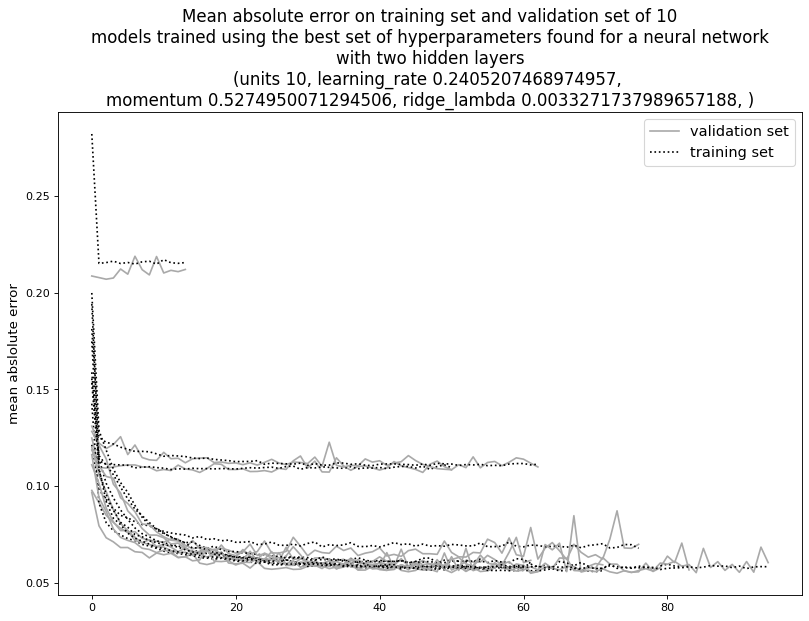

In [35]:
total_hp = 4
labels2 = ""
count = 1
for h_param in ["units", "learning_rate", "momentum", "ridge_lambda"]:
    hp_str = best_hp4[0].get(h_param)
    if (h_param == 'units'):
        hp_str *= 2
    labels2 += h_param + " " + str(hp_str) + ", "
    if(count % 2 == 0 and count != total_hp):
        labels2 += "\n"
    count += 1

list_values_val = [None]*n_trials
list_values_tr = [None]*n_trials

colours = ["darkgray", "black"]
linestyles = ["solid", "dotted"]

for i in range(n_trials):
    list_values_val[i] = hist2[i].history['val_mean_absolute_error']
    list_values_tr[i] = hist2[i].history['mean_absolute_error']
        
max_length = 0
for i in range(n_trials):
    if (max_length < len(list_values_tr[i])):
        max_length = len(list_values_tr[i])
        
time_ep = list(range(max_length))

plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values_val[i])], list_values_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values_tr[i])], list_values_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

legend = ["validation set", "training set"]

plt.title(
    "Mean absolute error on training set and validation set of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with two hidden layers\n("
    + labels2 + ")", size=15
)

plt.ylabel("mean abslolute error", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/mae_double_layer.png")
plt.show()

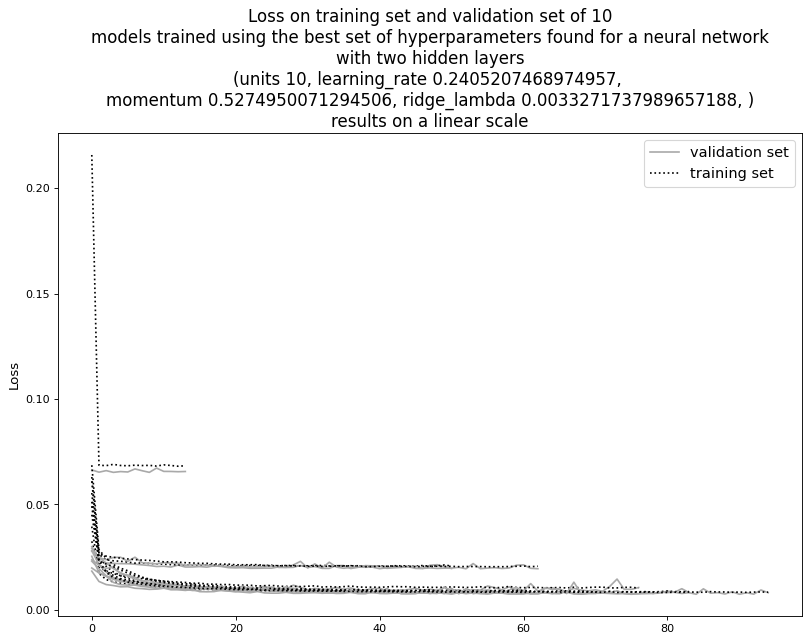

In [36]:
list_values2_val = [None]*n_trials
list_values2_tr = [None]*n_trials

for i in range(n_trials):
    list_values2_val[i] = hist2[i].history['val_loss']
    list_values2_tr[i] = hist2[i].history['loss']

plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values2_val[i])], list_values2_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values2_tr[i])], list_values2_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

plt.title(
    "Loss on training set and validation set of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with two hidden layers\n("
    + labels2 + ")\n" +
    "results on a linear scale", size=15
)

plt.ylabel("Loss", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/ms_loss_double_layer.png")
plt.show()

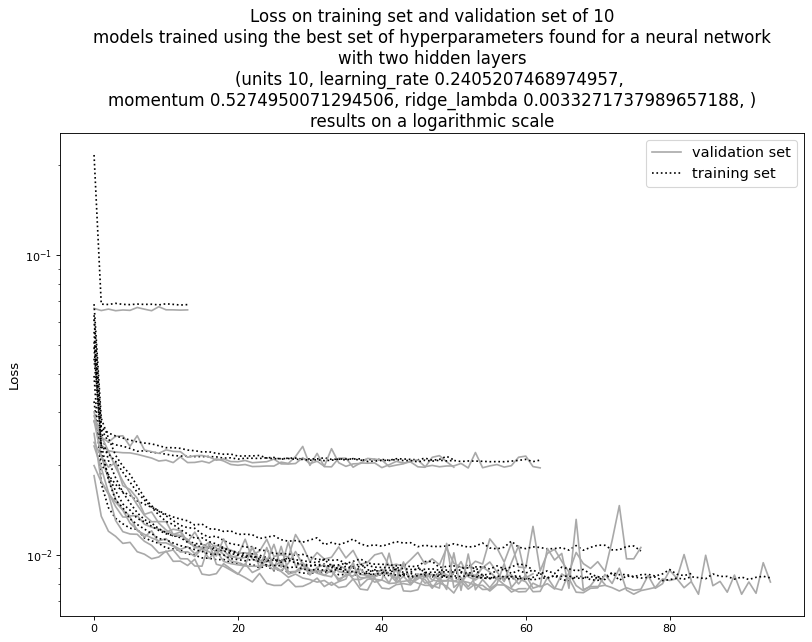

In [37]:
plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values2_val[i])], list_values2_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values2_tr[i])], list_values2_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

plt.title(
    "Loss on training set and validation set of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with two hidden layers\n("
    + labels2 + ")\n" +
    "results on a logarithmic scale", size=15
)

plt.ylabel("Loss", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/ms_loss_double_layer_log.png")
plt.yscale('log')
plt.show()

The neural networks with only one hidden layer have better results with respect to the others with two hidden layers. Therefore we decided to return a model among the ones obtained using a single hidden layer.  To retrieve a final model among the ones obtained using a random search, we chose the average model (among those having a single hidden layer) in terms of mean absolute error
on the validation set

In [55]:
for i in range(n_trials):
    list_values_val[i] = hist[i].history['val_mean_absolute_error']

final_values_val = [None]*n_trials
for i in range(n_trials):
    final_values_val[i] = list_values_val[i][len(list_values_val[i]) - 1]

list_scores = [None]*n_trials
for i in range(n_trials):
    list_scores[i] = [final_values_val[i], i]
    
list_scores = sorted(list_scores, key=itemgetter(0))

for i in range(n_trials):
    scr = list_scores[i][0]

index = list_scores[int(n_trials/2)][1]

avg_model_val_err = hist[index].history['val_mean_absolute_error']
list_length = len(avg_model_val_err)
final_val_err = avg_model_val_err[list_length - 1]


print(
    "The validation error on the final model for NN with random search is "
      + str(final_val_err) + "\n"
)

avg_model = models[index]
avg_model.save("results/ml_cup/nn_RandomSearch/avg_model_single_layer/")

The validation error on the final model for NN with random search is 0.05548655986785889

INFO:tensorflow:Assets written to: results/ml_cup/nn_RandomSearch/avg_model_single_layer/assets
